# Grover's Argorithm

入力 $f:\{0,1\}^{n} \to \{0,1\}$  
ある1つの$x_0$について$f(x_0) = 1$, 他の入力に対しては$f(x) = 0$


Grover's Argorithm は$O(\sqrt{2^n})$ の計算回数で、確率($1-\frac{1}{\sqrt{2^n}}$)で正しい答えを吐く

オラクルは先頭から$n$ bitを入力とした関数$f$の出力を、$n+1$ bit目に作用させる(排他論理和$\oplus$をとる)

$$
U_f\ |x>|b> = |x> |b\oplus f(x)>
$$

### だめなアルゴリズム例

$$
\begin{align}
|0^n> |0> &\to (\frac{1}{\sqrt{2}} [|0>+|1>)]^{\otimes n} \otimes |0>\ ...(Hadamard\ to\ n\ \rm{bit})\\
 &= \frac{1}{\sqrt{N}} \sum_{x\in \{1,0\}^n} |x>|0>\ ...(U_f\ to\ n\ \rm{bit})\\
 &\to \frac{1}{\sqrt{N}} \sum_{x\in \{1,0\}^n} |x>|f(x)>
\end{align}
$$

$f(x)=1$を得る可能性は$\frac{1}{2^n}$なので何も嬉しくない

### Groverのすごいアルゴリズム

$$
\begin{align}
|0^n> |0> &\to |0^n> |1> \\
 &= \frac{1}{\sqrt{N}} \sum_{x\in \{1,0\}^n} |x>\otimes \frac{1}{\sqrt{2}}(|0>-|1>) \ \ ...(Hadamard)\\
 &\to \frac{1}{\sqrt{N}} \sum_{x\in \{1,0\}^n} |x>\otimes \frac{1}{\sqrt{2}}(|0\oplus f(x)>-|1\oplus f(x)>) \\
 &\to \frac{1}{\sqrt{N}} \sum_{x\in \{1,0\}^n} (-1)^{f(x)} |x>\otimes \frac{1}{\sqrt{2}}(|0>-|1>) \\
 &\to \frac{1}{\sqrt{N}} \bigl (-|x_0> + \sum_{x \neq x_0} |x> \bigr) \otimes \frac{1}{\sqrt{2}}\bigl(|0>-|1>\bigr) \\
\end{align}
$$


最後の式変形は、$x=x_0$の時のみ$f(x)=1$のため符号が反転することを用いている  
最後に、先頭 $n$ bitに拡散行列$D_N$をかけると
$$
\frac{1}{\sqrt{N}} \biggl (\frac{3-4/N}{\sqrt{N}}|x_0> + \sum_{x \neq x_0} \frac{1-N/2}{\sqrt{N}}|x> \biggr) \otimes \frac{1}{\sqrt{2}}\bigl(|0>-|1>\bigr)
$$


$x=x_0$が測定される確率が強められている。
これを繰り返した後にこの状態を測定すると、高い確率で正解のビット列$x=x_0$が得られる。
ただしこの確率の変化は周期性があり、正解が得られる確率が最も高くなる繰り返し数は
$$
\frac{\pi}{4\theta}\ \ \ \ \biggl(\cos{\theta} = \sqrt{1-\frac{1}{N}}\biggr)
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
class Qbits:
    def __init__(self, initial):
        self.states = []
        for i in range(len(initial)):
            if initial[i]==1:# |1>
                self.states.append(np.array([0+0j,1+0j]))
            else:
                self.states.append(np.array([1+0j,0+0j]))
    

    def tensorProd(self, a, b):
        dim_a = len(a)
        dim_b = len(b)
        k = np.zeros(dim_a*dim_b) + 0j
        ite = 0
        for i in range(dim_a):
            for j in range(dim_b):
                k[ite] = a[i]*b[j]
                ite += 1
        return k
    
    def outputTensorProduct(self):
        out = self.states[0]
        for i in range(1, len(self.states)):
            out = self.tensorProd(out, self.states[i])
        return out
    
    def Hadamard(self, start, end):
        H = np.array([[1,1],[1,-1]]) / np.sqrt(2)
        for i in range(start, end+1):
            self.states[i] = np.dot(H, self.states[i])
        
    def C_Hadamard(self, control, start, end):
        if self.states[control] == np.array([1,0]):
            self.Hadamard(start, end)
            
    def Rphase(self, i, k):
        R = np.array([[1,0],[0,np.exp(1j * np.pi / (2**k))]]) + 0j
        self.states[i] = np.dot(R, self.states[i])
        
    def C_Rphase(self, control, i, k):
        if self.states[control][1] == 1+0j:
            self.Rphase(i, k)
            
    def flipState(self):
        self.states.reverse()


In [3]:
class Grover(Qbits):
    def __init__(self, inputDim, ans):
        self.N = 2 ** inputDim
        self.states = []
        for i in range(inputDim):
            self.states.append(np.array([1+0j,0+0j]))
        self.states.append(np.array([0+0j,1+0j])) # append |1>
        self.Hadamard(0, len(self.states) - 1)
        self.ancilla = self.states[-1]
        self.states = self.states[:-1]
        self.states = self.outputTensorProduct()
        self.ans = ans
        self.D_matrix = np.zeros((self.N, self.N)) + 2/self.N - np.identity(self.N)
    
    def oplus(self, qubit, bit):
        if bit:
            tmp = np.copy(qubit[0])
            qubit[0] = np.copy(qubit[1])
            qubit[1] = np.copy(tmp)
        return qubit
        
    def Oracle(self):
        for i in range(len(self.states)):
            if i == self.ans:
                self.states[i] *= -1
    
    def D_operation(self):
        self.states = np.dot(self.D_matrix, self.states)
        
    def opt(self):
        self.Oracle()
        self.D_operation()
    
    def probs(self):
        probs = np.abs(self.states) **2
        return probs
        

searching dimension =  1024
answer =  419
iteretion =  25
probability of getting correct result =  0.9994612447445582


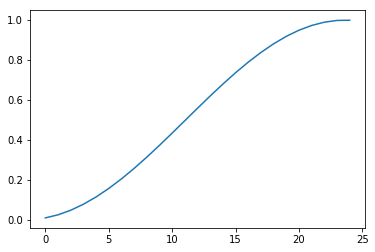

In [4]:
n = 10 # bit num
N = 2**n
ans = np.random.randint(0, N)

a = Grover(n, ans)
ans_probs_list = []

# 実用的には、繰り返し処理は Grover クラスに含めるべき
theta = np.arccos(np.sqrt(1-1/N))
ite = np.int(np.pi / 4 / theta)

for i in range(ite):
    a.opt()
    probs = a.probs()
    ans_probs_list.append(probs[ans])

print("searching dimension = ", N)
print("answer = ", ans)
print("iteretion = ", ite)
print("probability of getting correct result = ", ans_probs_list[-1])
plt.plot(ans_probs_list)